## Import dependencies

In [1]:
import io
import os

import boto3
import sagemaker
from sagemaker import get_execution_role, KMeans
from sagemaker.amazon.amazon_estimator import RecordSet

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans as SKLearnKMeans

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:172: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[05/29/25 16:58:29] INFO     Found credentials from IAM Role:                                   ]8;id=65912;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=37605;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[05/29/25 16:58:46] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=293715;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=31157;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

[05/29/25 16:58:49] INFO     generated new fontManager                                         ]8;id=235506;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=649088;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

In [2]:
%matplotlib inline

## Load the data
The credit card holder data is saved in a file called `CC GENERAL.csv` in an S3 bucket called `credit-card-behavior-analysis`

In [3]:
s3_client = boto3.client('s3')
data_bucket_name = 'credit-card-behavior-analysis'

[05/29/25 17:01:01] INFO     Found credentials from IAM Role:                                   ]8;id=427174;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=894671;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

In [4]:
response = s3_client.get_object(Bucket=data_bucket_name, Key='CC GENERAL.csv')

In [5]:
response_body = response['Body'].read()

## Explore the data
Load the data into a Pandas DataFrame object

In [6]:
credit_card_holders_df = pd.read_csv(io.BytesIO(response_body))

In [7]:
credit_card_holders_df.head()

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


### [Following is the Data Dictionary for Credit Card dataset](https://www.kaggle.com/datasets/arjunbhasin2013/ccdata/data):

* **CUST_ID**: Identification of Credit Card holder (Categorical)
* **BALANCE**: Balance amount left in their account to make purchases (
* **BALANCE_FREQUENCY**: How frequently the Balance is updated, score between 0 and 1 (1 = frequently updated, 0 = not frequently updated)
* **PURCHASES**: Amount of purchases made from account
* **ONEOFF_PURCHASES**: Maximum purchase amount done in one-go
* **INSTALLMENTS_PURCHASES**: Amount of purchase done in installment
* **CASH_ADVANCE**: Cash in advance given by the user
* **PURCHASES_FREQUENCY**: How frequently the Purchases are being made, score between 0 and 1 (1 = frequently purchased, 0 = not frequently purchased)
* **ONEOFFPURCHASESFREQUENCY**: How frequently Purchases are happening in one-go (1 = frequently purchased, 0 = not frequently purchased)
* **PURCHASESINSTALLMENTSFREQUENCY**: How frequently purchases in installments are being done (1 = frequently done, 0 = not frequently done)
* **CASHADVANCEFREQUENCY**: How frequently the cash in advance being paid
* **CASHADVANCETRX**: Number of Transactions made with "Cash in Advanced"
* **PURCHASES_TRX**: Numbe of purchase transactions made
* **CREDIT_LIMIT**: Limit of Credit Card for user
* **PAYMENTS**: Amount of Payment done by user
* **MINIMUM_PAYMENTS**: Minimum amount of payments made by user
* **PRCFULLPAYMENT**: Percent of full payment paid by user
* **TENURE**: Tenure of credit card service for user

In [15]:
credit_card_holders_df.describe()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


In [16]:
credit_card_holders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

_Looks like there are a few rows with missing values in these columns:_
* `CREDIT_LIMIT`
* `MINIMUM_PAYMENTS`

In [8]:
print(f'There are {len(credit_card_holders_df.dropna())} rows with non-null values.')

There are 8636 rows with non-null values.


## Prepare the training data
Select which columns will be features in the training data. Right now using the columns:
* `BALANCE`
* `PURCHASES`
* `CREDIT_LIMIT`

Drop all rows with any missing values in the feature columns

In [39]:
train_data_df = credit_card_holders_df[['BALANCE', 'PURCHASES', 'CREDIT_LIMIT']].dropna()

In [40]:
print(f'There are {len(train_data_df)} rows in the training data.')

There are 8949 rows in the training data.


<Axes: xlabel='BALANCE', ylabel='PURCHASES'>

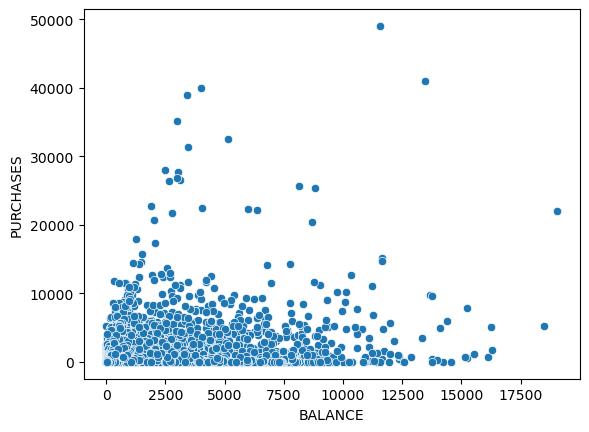

In [12]:
sns.scatterplot(data=train_data_df, x='BALANCE', y='PURCHASES')

In [46]:
train_data_coordinates = train_data_df.values.tolist()

In [47]:
train_data_coordinates[:5]

[[40.900749, 95.4, 1000.0],
 [3202.467416, 0.0, 7000.0],
 [2495.148862, 773.17, 7500.0],
 [1666.670542, 1499.0, 7500.0],
 [817.714335, 16.0, 1200.0]]

## Find k
Use the elbow method to determine the number of clusters. Right now using a SciKit-Learn KMeans model to determine the optimal value for `k`.

Using KMeans because:
* It's a great algorithm to start with
* It's a popular algorithm for customer segmentation problems like this one for credit card holders
* It's the only [built-in clustering algorithm provided by SageMaker](https://docs.aws.amazon.com/sagemaker/latest/dg/k-means.html)

There are other clustering algorithms that can be considered. [Based on this guide](https://www.geeksforgeeks.org/choosing-the-right-clustering-algorithm-for-your-dataset/), here are some other options:
* Hierarchical Clustering: This works well with smaller datasets like this one
* DBSCAN: Good for clustering outliers together
* Gaussian Mixture Models (GMM): Creates "soft" clusters in which data points are assigned a probability to belonging to each cluster

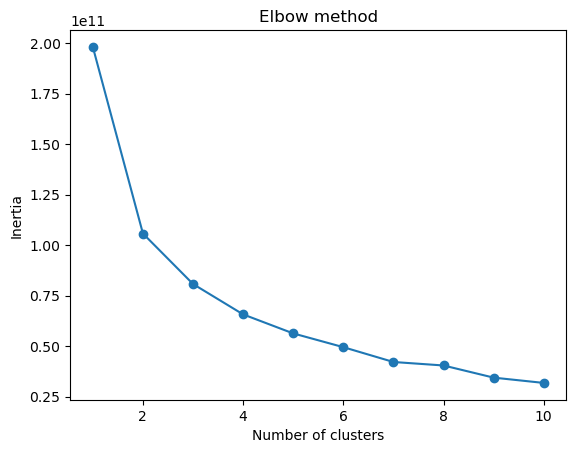

In [48]:
# Reference: https://www.w3schools.com/python/python_ml_k-means.asp

# Inertia is the sum of the squared distances between each data point and the centroid of the cluster.
# The elbow is where the the interia becomes more linear.

inertias = []

for i in range(1,11):
    kmeans = SKLearnKMeans(n_clusters=i)
    kmeans.fit(train_data_coordinates)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The [silhouette score](https://builtin.com/data-science/elbow-method) can also be used instead of the elbow method to determine the optimal number of clusters. If there is no clear elbow then this is a good option.

Set the optimal number of clusters

In [16]:
optimal_number_of_clusters = 2

In [49]:
sklearn_kmeans_model = SKLearnKMeans(n_clusters=optimal_number_of_clusters)
sklearn_kmeans_model.fit(train_data_coordinates)

KMeans(n_clusters=2)

<Axes: xlabel='BALANCE', ylabel='PURCHASES'>

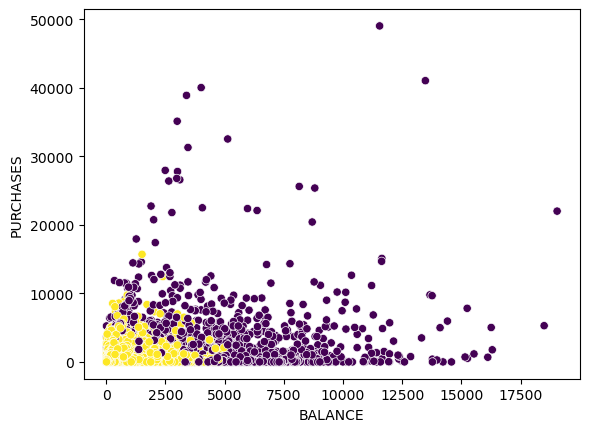

In [50]:
sns.scatterplot(data=train_data_df, x='BALANCE', y='PURCHASES', c=sklearn_kmeans_model.labels_)

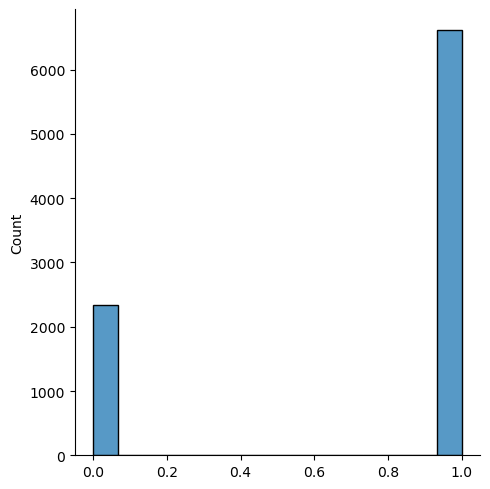

In [19]:
sns.displot(sklearn_kmeans_model.labels_)

## Create the model
Create the SageMaker KMeans model using the `k` value found with the SciKit-Learn KMeans model

Specify the IAM role SageMaker should use for accessing S3 which contains the training data and model artifacts

In [20]:
role = get_execution_role()

Convert the training data to a Numpy array containing 32 bit floats (otherwise the training job will fail)

In [21]:
train_data = train_data_df.values.astype('float32')

In [22]:
type(train_data)

numpy.ndarray

In [23]:
kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    output_path=f's3://{data_bucket_name}/output',
    k=optimal_number_of_clusters
)

## Train the model
Fit the SageMaker KMeans model with the training data which will create a training job

Convert the training data to a `RecordSet` which is the expected input type for a SageMaker KMeans model

In [24]:
train_data_records = kmeans.record_set(train=train_data)

In [25]:
train_data_records

(<class 'sagemaker.amazon.amazon_estimator.RecordSet'>, {'s3_data': 's3://sagemaker-us-east-2-607501192754/sagemaker-record-sets/KMeans-2025-05-29-17-09-27-196/.amazon.manifest', 'feature_dim': 3, 'num_records': 8949, 's3_data_type': 'ManifestFile', 'channel': 'train', 'distribution': 'ShardedByS3Key'})

In [26]:
%%time
kmeans.fit(records=train_data_records)

[05/29/25 17:09:44] INFO     Same images used for training and inference. Defaulting to image     ]8;id=422068;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=310434;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=733940;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=176649;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=600259;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=204816;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=717564;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=595407;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating training-job with name: kmeans-2025-05-29-17-09-44-488        ]8;id=923606;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=19814;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#1042\1042]8;;\

2025-05-29 17:09:45 Starting - Starting the training job...
2025-05-29 17:10:19 Downloading - Downloading input data...
2025-05-29 17:10:40 Downloading - Downloading the training image......
2025-05-29 17:11:41 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[05/29/2025 17:11:53 INFO 140689949407040] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '_log_level': 'info', '_num_gpus': 'auto', '_num_kv_servers': '1', '_num

## Create a prediction endpoint

In [27]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

[05/29/25 17:13:52] INFO     Same images used for training and inference. Defaulting to image     ]8;id=126353;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=724692;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=304376;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=996354;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Creating model with name: kmeans-2025-05-29-17-13-52-297               ]8;id=112892;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=64880;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4094\4094]8;;\

                    INFO     Creating endpoint-config with name kmeans-2025-05-29-17-13-52-297      ]8;id=174966;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=575208;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#6019\6019]8;;\

[05/29/25 17:13:53] INFO     Creating endpoint with name kmeans-2025-05-29-17-13-52-297             ]8;id=918512;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=539117;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4841\4841]8;;\

-------!CPU times: user 112 ms, sys: 536 μs, total: 113 ms
Wall time: 4min 2s


## Make predictions
Send the training data to the prediction endpoint so that the model can predict which cluster each credit card holder belongs to

In [28]:
%%time
result = kmeans_predictor.predict(train_data)

CPU times: user 267 ms, sys: 3.65 ms, total: 271 ms
Wall time: 682 ms


## Label data with predictions
Label which cluster each credit card holder is predicted to belong to

In [29]:
result[0]

label {
  key: "distance_to_cluster"
  value {
    float32_tensor {
      values: 1818.55261
    }
  }
}
label {
  key: "closest_cluster"
  value {
    float32_tensor {
      values: 1
    }
  }
}

In [30]:
cluster_labels = [r.label["closest_cluster"].float32_tensor.values[0] for r in result]

In [31]:
pd.DataFrame(cluster_labels)[0].value_counts()

1.0    6347
0.0    2602
Name: 0, dtype: int64

In [33]:
predictions_df = pd.concat([train_data_df, pd.DataFrame(data=cluster_labels, columns=['Cluster'])], axis=1)

<Axes: xlabel='BALANCE', ylabel='PURCHASES'>

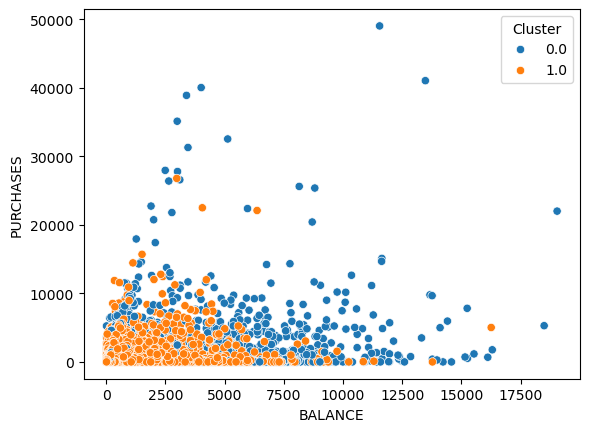

In [34]:
sns.scatterplot(data=predictions_df, x='BALANCE', y='PURCHASES', hue='Cluster')

<Axes: xlabel='BALANCE', ylabel='CREDIT_LIMIT'>

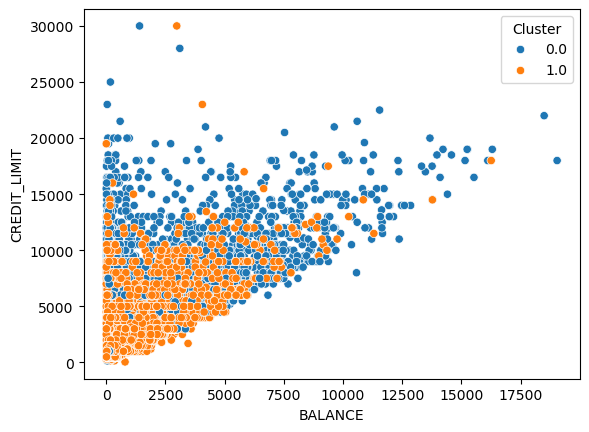

In [36]:
sns.scatterplot(data=predictions_df, x='BALANCE', y='CREDIT_LIMIT', hue='Cluster')

<Axes: xlabel='PURCHASES', ylabel='CREDIT_LIMIT'>

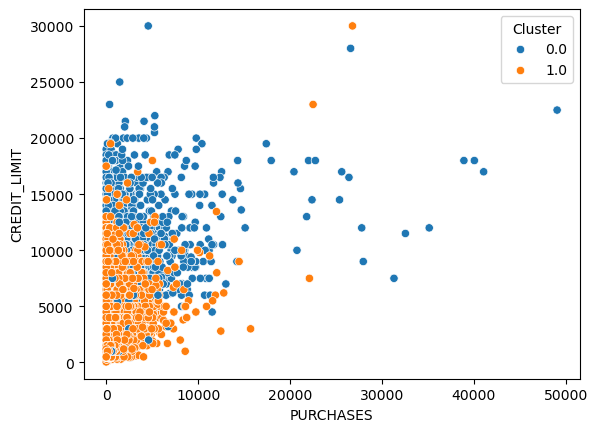

In [37]:
sns.scatterplot(data=predictions_df, x='PURCHASES', y='CREDIT_LIMIT', hue='Cluster')

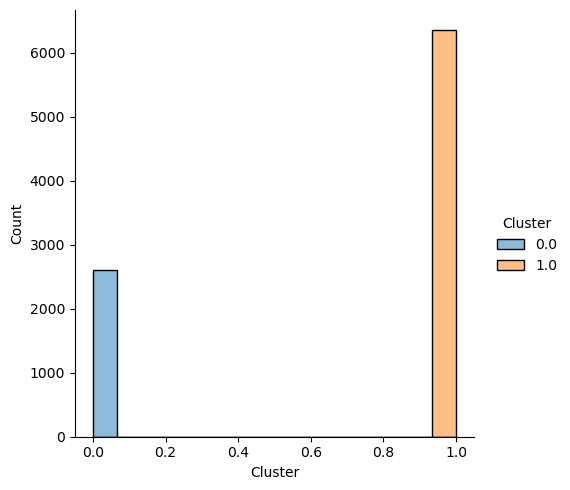

In [35]:
sns.displot(data=predictions_df, x='Cluster', hue='Cluster')

## Interpret the predictions
Try to explain what group of credit card holders each cluster represents
* Cluster 0: These are high spenders. On average they have higher balances, purchases, and credit limits.
* Cluster 1: These are conservative spenders. 

## Delete the prediction endpoint

In [51]:
kmeans_predictor.delete_endpoint()

[05/29/25 17:52:25] INFO     Deleting endpoint configuration with name:                             ]8;id=792201;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=267491;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4995\4995]8;;\
                             kmeans-2025-05-29-17-13-52-297                                                        

                    INFO     Deleting endpoint with name: kmeans-2025-05-29-17-13-52-297            ]8;id=786523;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py\session.py]8;;\:]8;id=494421;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/session.py#4985\4985]8;;\

In [55]:
predictions_df.head(500).to_csv('credit-card-behavior-analysis-predictions-sample.csv', index=None)